# Import Libraries and Packages

In the cell below titled "Importing Libraries", you have to import all the libraries and packages required for the script to run. \
If there is an error, it generally means that you don't have that library in your computer.

To install a library on your computer, use the following command on your Command Prompt or PowerShell or any other Terminal

pip install library_name

For eg:

pip install numpy \
pip install matplotlib

In [1]:
## IMPORTING LIBRARIES

import traitlets
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from numpy import genfromtxt
import math
from tkinter import Tk, filedialog
from ipywidgets import *
from IPython.display import clear_output, display, Javascript
from IPython.core.display import display, HTML
import PySimpleGUI as sg
import csv
import plotly.graph_objects as go
import plotly.express as px

import pytesseract
import cv2
import re

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

from lmfit.models import LinearModel, LorentzianModel, QuadraticModel
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from lmfit import Model
import statistics
from statistics import stdev
from scipy.signal import find_peaks

import photutils
#import astropy.tablep

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

from matplotlib.ticker import MaxNLocator
from matplotlib.figure import Figure


%matplotlib inline

# Defining Fucntions

In the cells below we will define all the functions necessary in the code. \
There might be a few funcitons that aren't needed, but it is advised to just run all the cells below to aovid any confusion.

## Function for creating select files dialogue

In [2]:
## FUNCTIONS:

# Function for creating select files dialogue
def select_files(b):
    root = Tk()
    root.withdraw()                                        # Hide the main window
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=True)    # List of selected fileswill be set to b.value
    f = b.files
    b.description = "Files Selected"
    b.icon = "check-square-o"
    b.style.button_color = "lightgreen"
    #clear_output()
    # Adding the dot variable helps you access the variable value outside the function.
    select_files.selectfs = SelectMultiple(options=f, value=[f[0]], disabled=False, layout=Layout(width='100%', height='300px'))
    print("Selected files:")
    display(select_files.selectfs) 

## Function for peak detection

In [3]:
# Function for peak detection

def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(3,3)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

## Function 2 for peak detection

In [4]:
# Function 2 for peak detection

def peak2d(array):
    '''This function finds the peak in a 2D array by the
       recursive method.

       Complexity: O(n log m)'''

    n = len(array)
    m = len(array[0])

    j = m//2

    row = [i[j] for i in array]

    i = row.index(max(row))

    print(i, j)

    if j > 0 and array[i][j] < array[i][j-1]:
        return peak2d([row[:j] for row in array])

    elif j < m - 1 and array[i][j] < array[i][j+1]:
        return peak2d([row[j:] for row in array])

    else:
        return i,j,array[i][j]

## Function for distance calculation

In [5]:
# Function for distance calculation

def dist_calc(x,y,peak_x,peak_y):
    
    return np.sqrt((x-peak_x)**2 + (y-peak_y)**2)

## Function for angle caluclaiton

In [6]:
# Function for angle caluclaiton

def ang_calc(x,y,dist,i,j,peak_x,peak_y):
    
    rel_x = x-peak_x
    rel_y = y-peak_y
    
    num = rel_x[i]*rel_x[j] + rel_y[i]*rel_y[j]
    den = dist[i]*dist[j]
    frac = num/den
    
    return math.degrees(np.arccos(frac))
    

## Function for gaussian fitting

In [7]:
# Function for gaussian fitting 

def gaussian_2d(xy_mesh, offset, amp, xc, yc, sigma_x, sigma_y):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = offset+(amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y))
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

## Function for radial integration

In [8]:
# Function for radial integration

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

## Function for stacking images beside each other

In [9]:
# Function for stacking images beside each other

def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

## Empty function

In [10]:
# Empty function

def empty(a):
    pass

## Function for phase detection

In [11]:
# Function for phase detection

def phase_detect(index_file_path,invdis):
    
    index_data = genfromtxt(index_file_path, delimiter=',')

    d_spacing_A = np.array(index_data[1:,0])
    i_h = np.array(index_data[1:,1])
    i_k = np.array(index_data[1:,2])
    i_l = np.array(index_data[1:,3])
    #i_label = np.array(index_data[1:,4])

    d_diff = np.zeros(shape=(len(invdis),len(d_spacing_A)),dtype=np.float64)
    p_d_used = np.zeros(shape=(len(invdis)),dtype=np.float64)
    p_d_diff = np.zeros(shape=(len(invdis)),dtype=np.float64)
    p_h = np.zeros(shape=(len(invdis)),dtype=np.int32)
    p_k = np.zeros(shape=(len(invdis)),dtype=np.int32)
    p_l = np.zeros(shape=(len(invdis)),dtype=np.int32)
    p_ind = np.zeros(shape=(len(invdis),3),dtype=np.int32)
    p_d_diff_short = np.zeros(shape=(int(len(invdis)/2)),dtype=np.float64)
    #p_label = []

    for i in range(len(invdis)):
        d_diff[i,:] = abs(10*invdis[i]-d_spacing_A)
        i_min = np.argmin(d_diff[i,:])
        #print(i_min)
        p_d_used[i] = d_spacing_A[i_min]
        p_d_diff[i] = d_diff[i,i_min]
        p_h[i] = i_h[i_min]
        p_k[i] = i_k[i_min]
        p_l[i] = i_l[i_min]
        p_ind[i] = [p_h[i],p_k[i],p_l[i]]
        
    for i in range(int(len(invdis)/2)):
        p_d_diff_short[i] = p_d_diff[i]
        
    #fields=['first','second','third']
    
    return p_d_diff_short, p_ind

## Funciton for Saving Statistical Analysis

This is an important function for your code and data saving. You need to change a few things everytime you run to avoid overwriting on files.

There are two file names you would need to change once, and one file name you'd need to change everytime.

**Change once:**

`phase_index_path_1`  
`phase_index_path_2`  
Add names of files containing index information for the respective materials you are searching for 


**Change everytime:**

Code Line 75

`with open(r'04-22-2021-Alex-Stat_Analysis-Open.csv', 'a') as f:`  
Change the string inside the single quotes to your desired file name.

*Note: If you want to add a 3rd material, follow the steps below:*
- *un-comment Line 7,10,16,29*
- *Add file name in Code line 7*
- *Change the no. 4 to 5 in Code line 18*



In [12]:
# Funciton for Sacing Statistical Analysis

def stat_analysis_save(invdis,intes,x,y):
    
    phase_index_path_1 = str('aNaYF4_index.csv') 
    phase_index_path_2 = str('cYF3_index.csv')
    #phase_index_path_3 = str('g_index.csv')
    ph1_p_d_diff, ph1_p_ind = phase_detect(phase_index_path_1,invdis)
    ph2_p_d_diff, ph2_p_ind = phase_detect(phase_index_path_2,invdis)
    #ph3_p_d_diff, ph3_p_ind = phase_detect(phase_index_path_3,invdis)
    
    ph1_t = np.transpose(ph1_p_d_diff)
    #ph1_ind_t = np.transpose(ph1_p_ind)
    ph2_t = np.transpose(ph2_p_d_diff)
    #ph2_ind_t = np.transpose(ph2_p_ind)
    #ph3_t = np.transpose(ph3_p_d_diff)
    
    ph_total = np.zeros(shape=(len(ph1_p_d_diff),4))
    
    invdis_imp_ar = []
    intes_imp_ar = []
    wt_d_ar = []
    
    l_lim = 3.05
    h_lim = 3.35
    
    for i in range(len(ph1_p_d_diff)):
        ph_total[i,0] = counter
        ph_total[i,1] = 10*invdis[i]
        ph_total[i,2] = ph1_t[i]
        ph_total[i,3] = ph2_t[i]
        #ph_total[i,4] = ph3_t[i]
        
        if ph_total[i,1] > l_lim and ph_total[i,1] < h_lim:
            
            invdis_imp = 10*invdis[i]
            invdis_imp_ar = np.append(invdis_imp_ar,invdis_imp)
            print(invdis_imp_ar)
            
            print(intes[i])
            intes_imp = intes[i]
            intes_imp_ar = np.append(intes_imp_ar,intes_imp)
            print(intes_imp_ar)
            
            wt_d = intes_imp*invdis_imp
            wt_d_ar = np.append(wt_d_ar,wt_d)
            print(wt_d_ar)
            
            #cv2.circle(imprev, (x,y), 6, (255,0,0), 2)
            
    #for i in range(len(ph1_p_d_diff)):
    #if any(ph_total[:,1] > 3.0) and any(ph_total[:,1] < 3.2):   
    d_avg = np.sum(wt_d_ar)/np.sum(intes_imp_ar)
    print(d_avg)
    
    ## BGR - BLUE, GREEN, RED
    
    # h_lim - BLUE - 255, 0, 0
    # l_lim - RED - 0, 0, 255
    
    c = (d_avg-l_lim)/(h_lim-l_lim)
    c_gray = c*255
    spot_col = (255-c_gray,0,0+c_gray)
    
    if d_avg > l_lim and d_avg < h_lim:
        cv2.circle(imprev, (x,y), 6, spot_col, 2)
                
        
        #break
        
        #ph_total[i,3] = ph3_t[i]
        #ph_total[i,3] = ph1_ind_t[i,:]
        #ph_total[i,4] = ph2_ind_t[i,:]
    
    with open(r'04-22-2021-Alex-Stat_Analysis-Open.csv', 'a') as f:
        writer = csv.writer(f)
        for i in range(len(ph1_p_d_diff)):
            writer.writerow(ph_total[i])
        #writer.writerow(ph1_p_d_diff)
        #writer.writerow(ph2_p_d_diff)

## Function for Data Printing

Important function for data printing 

Code Line 5:  
`index_file_path = str('NYF_index')`  
Change the name inside single quotes to the name of file which contains indexing for all the materials

Code Line 37 to 42:  
Change the name in Code Line 39 and 42 based on your index file and the value in Code Line 37 and 40 respectively.

Code Line 89:  
`with open(r'04-22-2021-Alex-All_data-Open.csv', 'a') as f:`
Change the string inside the single quotes to your desired file name.

*Note: If you want to add a 3rd material, follow the steps below:*
- *un-comment Line 43,44,45*


In [32]:
# Function for saving and prinitng data to file

def data_printing(invdis,intes,ang,x,y):
    
    index_file_path = str('NYF_index')
    index_data = genfromtxt(index_file_path + str('.csv'), delimiter=',')

    d_spacing_A = np.array(index_data[1:,0])
    i_h = np.array(index_data[1:,1])
    i_k = np.array(index_data[1:,2])
    i_l = np.array(index_data[1:,3])
    i_label = np.array(index_data[1:,4])
    

    d_diff = np.zeros(shape=(len(invdis),len(d_spacing_A)),dtype=np.float64)
    p_d_used = np.zeros(shape=(len(invdis)),dtype=np.float64)
    p_d_diff = np.zeros(shape=(len(invdis)),dtype=np.float64)
    p_h = np.zeros(shape=(len(invdis)),dtype=np.int32)
    p_k = np.zeros(shape=(len(invdis)),dtype=np.int32)
    p_l = np.zeros(shape=(len(invdis)),dtype=np.int32)
    p_ind = np.zeros(shape=(len(invdis),3),dtype=np.int32)
    p_label = []
    index_label = []

    for i in range(len(invdis)):
        d_diff[i,:] = abs(10*invdis[i]-d_spacing_A)
        #print(d_diff[i,:])
        i_min = np.argmin(d_diff[i,:])
        #print(i_min)
        p_d_used[i] = d_spacing_A[i_min]
        p_d_diff[i] = d_diff[i,i_min]
        #print(p_d_diff)
        p_h[i] = i_h[i_min]
        p_k[i] = i_k[i_min]
        p_l[i] = i_l[i_min]
        p_ind[i] = [p_h[i],p_k[i],p_l[i]]
        if i_label[i_min] == 0:
            index_label.append(0)
            p_label.append("alpha NaYF4")
        elif i_label[i_min] == 1:
            index_label.append(1)
            p_label.append("Cubic YF3")
        #elif i_label[i_min] == 2:
        #    index_label.append(2)
            #p_label.append("Hexagonal Diamond")
    za = ["NIL"]

    for i in range (len(p_ind)):
        for j in range(len(p_ind)):
            if all(p_ind[i] == p_ind[j]):
                #za = "NIL"
                continue
            else:
                za = np.cross(p_ind[i],p_ind[j])
                #print(za)
    result_data = np.zeros(shape=(len(invdis),9))
    #result_data[0][0] = "Zone-axis"
    #result_data[0,:3] = za[:]

    for i in range(len(invdis)):
        
        result_data[i][0] = counter
        result_data[i][1] = 10*invdis[i]
        result_data[i][2] = p_d_used[i]
        #result_data[i+1][2] = p_d_diff[i]
        result_data[i][3] = p_h[i]
        result_data[i][4] = p_k[i]
        result_data[i][5] = p_l[i]
        result_data[i][6] = index_label[i]
        result_data[i][7] = x
        result_data[i][8] = y

    #np.savetxt("Result-"+str(counter)+".csv",result_data,delimiter=',')
    
    stat_analysis_save(invdis,intes,x,y)

    with open("Result_"+ index_file_path + str(counter)+".txt",'w') as f:
        f.write("Zone Axis: " + str(za))
        f.write("\n\nd-spacing (Angstrom)")
        for i in range(int(len(invdis)/2)):
            f.write("\n"+str(10*invdis[i])+"   "+str(p_d_used[i])+"   "+str(p_d_diff[i])+"   "+str(p_h[i])+"   "+str(p_k[i])+"   "+str(p_l[i]) + "   "+str(p_label[i]))
        f.write("\n\nAngles between peaks")
        for i in range(len(ang)):
            if i == 0 or i == int(len(ang)/2) or i == len(ang):
                continue
            else:
                f.write("\n"+str(ang[i,0]))
                
    with open(r'04-22-2021-Alex-All_data-Open.csv', 'a') as f:
        writer = csv.writer(f)
        for i in range(len(invdis)):
            writer.writerow(result_data[i])
            
    return index_label

## Function for peak detection method

Select if you want chose Method 1 (Auto) or Method 2 (Manual). Change the cell type to *markdown* for the method you don't want to use.

### Method 1 - Automatic

Change the *threshold* and *box_sz* based on your preferences:

Code Line 7 and 8: 

`threshold = 60`  
`box_sz = 11`

#### Method 1 - Automatic

def method_peak_detection(fit_residual,x,y):
    
    peak_x,peak_y,peak_intes = peak2d(fit_residual)
    
    threshold = 60
    box_sz = 11
    
    #mag_gray = cv2.cvtColor(fit_residual, cv2.COLOR_BGR2GRAY)
    detected_peaks = photutils.detection.find_peaks(fit_residual,threshold,box_size=(box_sz,box_sz))
    #print(detected_peaks)
    #print(detected_peaks.colnames)
    #detected_peaks = detected_peaks.remove_columns(['y_peak','peak_value'])
    detected_peaks = detected_peaks.as_array()
    #print(detected_peaks)
    lenp = len(detected_peaks)

    xval = np.zeros(shape=(lenp),dtype=np.float64)
    yval = np.zeros(shape=(lenp),dtype=np.float64)
    intes = np.zeros(shape=(lenp),dtype=np.float64)
    dist = np.zeros(shape=(lenp),dtype=np.float64)
    dist_cal = np.zeros(shape=(lenp),dtype=np.float64)
    invdis = np.zeros(shape=(lenp),dtype=np.float64)
    resp_intes = np.zeros(shape=(lenp),dtype=np.float64)
    ang = np.zeros(shape=(lenp,lenp),dtype=np.float64)
    wt_d = np.zeros(shape=(lenp),dtype=np.float64)

    # d-spacing calculation
    for i in range(np.shape(detected_peaks)[0]):
        xval[i] = detected_peaks[i][0]
        yval[i] = detected_peaks[i][1]
        intes[i] = detected_peaks[i][2]
        if xval[i] == peak_x and yval[i] == peak_y:
            continue
        else:
            dist[i] = dist_calc(xval[i],yval[i],peak_x,peak_y)
            for j in range(len(yval)):
                ang[i,j] = ang_calc(xval,yval,dist,i,j,peak_x,peak_y)
            dist_cal[i] = dist[i]*perpix
            resp_intes[i] = np.abs(peak_intes - intes[i])
            invdis[i]=1/dist_cal[i] ## d-spacing
            #wt_d[i] = intes[i]*10*invdis[i]
        
    
    #for i in range(len(invdis)):
        #if invdis[i]
        #if invdis[i] < 0.2:
            #cv2.circle(imprev, (x,y), 10, (200,100,90), cv2.FILLED) #BGR
            #break
        #else:
            #cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
            #break

    
    data_printing(invdis,intes,ang,x,y)
    
    #invdis_imp = []
    #intes_imp = []
    #wt_d = []
    
    #for i in range(len(invdis)):
     #   if any(m > 3.0 for m in 10*invdis) and any(m < 3.2 for m in 10*invdis):
            
      #      invdis_imp = np.append(invdis_imp,10*invdis[i])
       #     print(invdis_imp)
        #    intes_imp = np.append(intes_imp,intes[i])
         #   print(intes_imp)
          #  wt_d = intes_imp[i]*invdis_imp[i]
           # print(wt_d)
            #cv2.circle(imprev, (x,y), 6, (255,0,0), 2)
            
    #d_avg = np.sum(wt_d)/np.sum(intes_imp)
    #print(d_avg)
            
            
            
            
            #break
        #elif all(x == 0 for x in index_label):
        #cv2.circle(imprev, (x,y), 10, (255,0,0), cv2.FILLED)
        #    break
        #elif all(x == 1 for x in index_label):
        #cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
            #break
    
    pass
   

### Method 2 - Manual

You will get to chose the *threshold* and *box_sz* for every area you select

In [26]:
#### Method 2 - Manual

def method_peak_detection(fit_residual,x,y):
    
    peak_x,peak_y,peak_intes = peak2d(fit_residual)
    
    cv2.namedWindow("Peak Finding")
    cv2.resizeWindow("Peak Finding",640,100)
    cv2.createTrackbar("Threshold","Peak Finding",100,200,empty)
    cv2.createTrackbar("Box Size","Peak Finding",7,20,empty)
    #cv2.createTrackbar("Threshold","Peak Finding",50,200,empty)

    while(1):
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))

        # get current positions of four trackbars
        threshold = cv2.getTrackbarPos("Threshold","Peak Finding")
        box_sz = cv2.getTrackbarPos("Box Size","Peak Finding")

        #mag_gray = cv2.cvtColor(fit_residual, cv2.COLOR_BGR2GRAY)
        detected_peaks = photutils.detection.find_peaks(fit_residual,threshold,box_size=(box_sz,box_sz))
        #print(detected_peaks)
        #print(detected_peaks.colnames)
        #detected_peaks = detected_peaks.remove_columns(['y_peak','peak_value'])
        detected_peaks = detected_peaks.as_array()
        #print(detected_peaks)
        lenp = len(detected_peaks)

        xval = np.zeros(shape=(lenp),dtype=np.float64)
        yval = np.zeros(shape=(lenp),dtype=np.float64)
        intes = np.zeros(shape=(lenp),dtype=np.float64)
        dist = np.zeros(shape=(lenp),dtype=np.float64)
        dist_cal = np.zeros(shape=(lenp),dtype=np.float64)
        invdis = np.zeros(shape=(lenp),dtype=np.float64)
        resp_intes = np.zeros(shape=(lenp),dtype=np.float64)
        ang = np.zeros(shape=(lenp,lenp),dtype=np.float64)
        
        # d-spacing calculation
        for i in range(np.shape(detected_peaks)[0]):
            xval[i] = detected_peaks[i][0]
            yval[i] = detected_peaks[i][1]
            intes[i] = detected_peaks[i][2]
            if xval[i] == peak_x and yval[i] == peak_y:
                continue
            else:
                dist[i] = dist_calc(xval[i],yval[i],peak_x,peak_y)
                for j in range(len(yval)):
                    ang[i,j] = ang_calc(xval,yval,dist,i,j,peak_x,peak_y)
                dist_cal[i] = dist[i]*perpix
                resp_intes[i] = np.abs(peak_intes - intes[i])
                invdis[i]=1/dist_cal[i] ## d-spacing
        

        #for i in range(len(invdis)):
            #if invdis[i] < 0.2:
                #cv2.circle(imprev, (x,y), 10, (200,100,90), cv2.FILLED) #BGR
               # break
            #else:
                #cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
                #break
            
                
        fig_p, (axs1,axs2) = plt.subplots(1,2)
        axs1.plot(4,2,(2*i+1))
        axs1.imshow(fit_residual,cmap='gray')
        axs2.plot(4,2,(2*i+2) )
        axs2.imshow(fit_residual,cmap='gray')
        axs2.scatter(xval,yval,color='r')
        for i in range(len(xval)):
            axs2.arrow(peak_x,peak_y,(xval[i]-peak_x),(yval[i]-peak_y),color='b',linewidth=2)

        fig_p.canvas.draw()

        img_p = np.fromstring(fig_p.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_p  = img_p.reshape(fig_p.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_p = cv2.cvtColor(img_p,cv2.COLOR_RGB2BGR)
        #print(img_p.shape)
        
        #cv2.arrowedLine(img_p, (peak_x,pea), end_point, color, thickness)

        # display image with opencv or any operation you like
        #cv2.circle(img_p, (xval,yval), 10, (255,255,0), cv2.FILLED)
        cv2.imshow("Final Peak",img_p)
        
        #data_printing(invdis,intes,ang,x,y)
        
        k = cv2.waitKey(33) & 0xFF
        if k == 27:
            break

    cv2.destroyWindow("Peak Finding")
    cv2.destroyWindow("Final Peak")
    print(invdis)
    invdis = invdis[invdis != 0]
    #invdis = np.trim_zeros(invdis)
    print(invdis)
    
    index_label = data_printing(invdis,intes,ang,x,y)
    print(index_label)
    '''
    for i in range(len(invdis)):
        if any(x == 0 for x in index_label) and any(x == 1 for x in index_label):
            #cv2.circle(imprev, (x,y), 10, (0,0,255), cv2.FILLED)
            break
        elif all(x == 0 for x in index_label):
            #cv2.circle(imprev, (x,y), 10, (255,0,0), cv2.FILLED)
            break
        elif all(x == 1 for x in index_label):
            #cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
            break
    '''

    pass
        

## Function for radial integration method

In [23]:
# Function for radial integration method

def method_radial_integration(magnitude_spectrum,x,y):
    #profile = radial_profile(np.log(1+np.abs(magnitude_spectrum)),(ksize/2,ksize/2))
    profile = radial_profile(magnitude_spectrum,(ksize/2,ksize/2))
    
    # Adjust the st and en values from the x axis above to surround the lorentz peak
    cv2.namedWindow("Integration")
    cv2.resizeWindow("Integration",640,100)
    cv2.createTrackbar("Start","Integration",7,40,empty)
    cv2.createTrackbar("End","Integration",15,100,empty)
    #cv2.createTrackbar("Threshold","Peak Finding",50,200,empty)

    while(1):
        uncalibx = np.linspace(0,len(profile),len(profile))

        st = 0  # Adjust st to cut the radial profile at the start to remove the zero line
        #profile = radial_profile(np.log(1+np.abs(maskedfft)),(ksize/2,ksize/2))
        fig_mrl = plt.figure()
        plt.plot(uncalibx, profile[st:])

        fig_mrl.canvas.draw()

        img_mrl = np.fromstring(fig_mrl.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_mrl  = img_mrl.reshape(fig_mrl.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_mrl = cv2.cvtColor(img_mrl,cv2.COLOR_RGB2BGR)
        #print(img_p.shape)

        # display image with opencv or any operation you like
        #cv2.circle(img_p, (xval,yval), 10, (255,255,0), cv2.FILLED)
        #cv2.imshow("Complete Radial Integration",img_mrl)
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))

        # get current positions of four trackbars
        st = cv2.getTrackbarPos("Start","Integration")
        en = cv2.getTrackbarPos("End","Integration")
        
        invspace = np.linspace(0,len(profile),len(profile))*perpix
        xdata, ydata = invspace[st:en], profile[st:en]

        mod = LorentzianModel()+LinearModel()
        print(mod.param_names)
        pars = mod.make_params(amplitude=150, center=3.8, sigma=1, slope=1, intercept=160)
        init = mod.eval(pars, x=xdata)
        out = mod.fit(ydata, pars, x=xdata)
        print(out.fit_report(min_correl=0.5))

        fig_rl = plt.figure()
        ax1 = fig_rl.add_subplot(1,1,1)
        #ax1.set_title(tail+" - "+txt)
        ax1.scatter(xdata, ydata)
        ax1.plot(xdata, out.best_fit, 'r-')
        #plt.show()
        
        fig_rl.canvas.draw()

        img_rl = np.fromstring(fig_rl.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_rl = img_rl.reshape(fig_rl.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_rl = cv2.cvtColor(img_rl,cv2.COLOR_RGB2BGR)
        #print(img_p.shape)

        # display image with opencv or any operation you like
        #cv2.circle(img_p, (xval,yval), 10, (255,255,0), cv2.FILLED)
        #cv2.imshow("Radial Integration",img_rl)
        imgStack = stackImages(0.7,([img_mrl,img_rl]))
 
        # imgHor = np.hstack((img,img))
        # imgVer = np.vstack((img,img))
        #
        # cv2.imshow("Horizontal",imgHor)
        # cv2.imshow("Vertical",imgVer)
        cv2.imshow("Final Integration",imgStack)
        
        k = cv2.waitKey(1)
        if k == 27:
            break
            
    print(1/out.best_values['center'])
            
    #if 1/out.best_values['center'] < 0.2:
    #    cv2.circle(imprev, (x,y), 10, (200,100,90), cv2.FILLED)
    #else:
    #    cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
            
    #cv2.destroyWindow("Compelte Radial Integration")
    #cv2.destroyWindow("Radial Integration")
    cv2.destroyWindow("Final Integration")
    cv2.destroyWindow("Integration")
    
    pass

## Function to select method

In [16]:
## Function to select method

def select_method(fit_residual,x,y):
    
    layout = [[sg.Text("Select the method")], [sg.Button("PD")], [sg.Button("RI")]]

    # Create the window
    window = sg.Window("Method", layout)

    # Create an event loop
    while True:
        event, values = window.read()
        # End program if user closes window or
        # presses the OK button
        if event == "PD":
            #break
            window.close()
            method_peak_detection(fit_residual,x,y)
            break
        elif event == "RI":
            window.close()
            method_radial_integration(fit_residual,x,y)
            break
    #window.close()

## Function for click and point on Image

If you want to do *Manual Gaussian background*, then remove the *'''*  from Code Line 32 and 71 to uncomment that entire block of code.  
If you want to do *Auto Gaussian background*, then leave that Code Block from Code LIne 32 to 71 commented, and set an *offset* and *amp* below that


The *peak detection method* is hard-coded right now for d-spacing calculation, in the Code Line 95:  
`method_peak_detection(fit_residual,x,y)`

If you want to get the option to select the method between *peak detection method* and *radial integration method* everytime you click on an area, then comment Code Line 95, and un-comment Code Line 96:  
`select_method(fit_residual,x,y)`


Set the image name for the final image on Code Line 98:  
`cv2.imwrite("04-22-2021-Alex-Open.png",imprev)`

In [17]:
# Function for click and point on Image

def mousepoint(event, x, y, flags, params):
    global counter
    if event == cv2.EVENT_LBUTTONDOWN and x>int(kernel_side/2) and y>int(kernel_side/2) and x<int(prevsize[0]-kernel_side/2) and y<int(prevsize[0]-kernel_side/2):
        counter = counter+1
        print("Preview location {}: {}, {}".format(counter,x,y))
        prev_locations.append([x,y])
        img_locations.append([int(x/prev_scale),int(y/prev_scale)])
        #cv2.circle(imprev, (x,y), 2, (255,0,0), cv2.FILLED)
        txt = "A"+str(counter)
        #cv2.putText(imprev,txt, (x,int(y+kernel_side/2+3)), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,255,255),1)
        #cv2.circle(imprev, (x,y), 7, (255,0,0), 2)
        #cv2.rectangle(imprev, (int(x-kernel_side/2),int(y-kernel_side/2)), (int(x+kernel_side/2),int(y+kernel_side/2)), (255,255,255), 1)
        #cv2.rectangle(imprev, (int(x-kernel_side/2),int(y-kernel_side/2)), (int(x+kernel_side/2),int(y+kernel_side/2)), (255,255,255), 1)
        cv2.imshow(tail, imprev)
        
        
        imcut = img[int(y/prev_scale-kernel_sideraw/2):int(y/prev_scale+kernel_sideraw/2),int(x/prev_scale-kernel_sideraw/2):int(x/prev_scale+kernel_sideraw/2)]
        imcut = cv2.cvtColor(imcut,cv2.COLOR_BGR2GRAY)
        #fft = np.fft.fft2(imcut)
        #magnitude_spectrum = np.fft.fftshift(fft)
        
        fft = np.fft.fft2(imcut)
        fshift = np.fft.fftshift(fft)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        #cv2.imread(magnitude_spectrum)
        #cv2.imshow("Residual",magnitude_spectrum)
        #magnitude_spectrum = cv2.UMat(magnitude_spectrum)
        
        ####
        '''
        fig_3 = plt.figure()
        ax = fig_3.add_subplot(1, 1, 1)
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, magnitude_spectrum, cmap='viridis', edgecolor='none')
        ax.view_init(0, 90)
        #plt.show()
        fig_3.canvas.draw()
        
        img_1 = np.fromstring(fig_3.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_1  = img_1.reshape(fig_3.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_1 = cv2.cvtColor(img_1,cv2.COLOR_RGB2BGR)
        
        # display image with opencv or any operation you like
        cv2.imshow("Spectrum",img_1)
        #cv2.resize(cv2.UMat(img_1),(480,480))
        #cv2.resizeWindow("3D-plot",480,480)
        
        cv2.namedWindow("Parameter Adjustment")
        cv2.resizeWindow("Parameter Adjustment",640,80)
        cv2.createTrackbar("Offset","Parameter Adjustment",100,300,empty)
        cv2.createTrackbar("Amplitude","Parameter Adjustment",38,50,empty)
        
        while(1):
            #cv2.imshow("3D-plot",img_1)
            # get current positions of four trackbars
            offset = cv2.getTrackbarPos("Offset","Parameter Adjustment")
            amp = cv2.getTrackbarPos("Amplitude","Parameter Adjustment")
            
            k = cv2.waitKey(1) & 0xFF
            if k == 27:
                break
                
            #print(offset)
            
        cv2.destroyWindow("Parameter Adjustment")
        cv2.destroyWindow("Spectrum")
        '''
        #####

        offset = 131 # Alex
        amp = 21 # Alex
        
        xc, yc = np.median(xx), np.median(yy)
        #xc, yc = 40,40
        sigma_x, sigma_y = xx[-1]/2 , yy[-1]/2

        # define some initial guess values for the fit routine
        guess_vals = [offset, amp*2, xc*0.8, yc*0.8, sigma_x/1.5, sigma_y/1.5]

        # perform the fit, making sure to flatten the noisy data for the fit routine 
        fit_params, cov_mat = curve_fit(gaussian_2d, (X,Y), np.ravel(magnitude_spectrum), p0=guess_vals)

        # calculate fit parameter errors from covariance matrix
        fit_errors = np.sqrt(np.diag(cov_mat))

        # manually calculate R-squared goodness of fit
        fit_residual = magnitude_spectrum - gaussian_2d((X,Y), *fit_params).reshape(np.outer(xx,yy).shape)
        fit_Rsquared = 1 - np.var(fit_residual)/np.var(magnitude_spectrum)
        
        
        method_peak_detection(fit_residual,x,y)        
        #select_method(fit_residual,x,y)

        cv2.imwrite("04-22-2021-Alex-Open.png",imprev)
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))

# Running Code

## Button to select files

In [18]:
# Button to select files

# Open file(s)
################################################################################

fileselect = Button(description="File Select")
fileselect.icon = "square-o"
fileselect.style.button_color = "orange"
fileselect.on_click(select_files)


display(fileselect)

################################################################################

Button(description='File Select', icon='square-o', style=ButtonStyle(button_color='orange'))

Selected files:


SelectMultiple(index=(0,), layout=Layout(height='300px', width='100%'), options=('D:/OneDrive - UW/Research/Pr…

## Scale calibration using Image Analysis

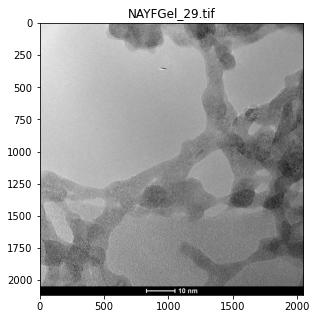

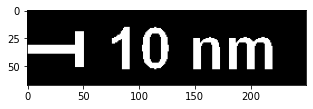

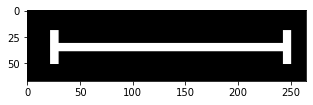

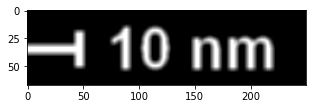

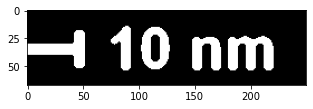

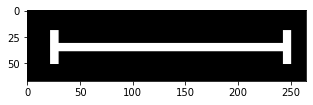

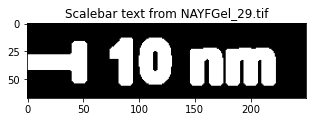

Text detected: 10 nm

Number separated: 10.0
Unit found:  nm



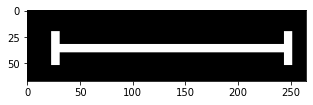

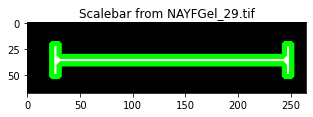

Pixel length: 228 	 Scale: 10.0
Calibration: 22.80000 pixel/ nm

_________________________________________________________________________________________________


In [19]:
# Scale calibration using Image Analysis

%matplotlib inline

# Copy the information from file
################################################################################

f = select_files.selectfs.value
fnames = [None] * len(f)
scalenos = np.zeros(len(f))
scaleunits = [None] * len(f)
calibs = np.zeros(len(f))

################################################################################


# Plotting the image and obtaining sacle bar text and length
################################################################################

for i in range(0,len(f)):
    plt.rcParams['figure.figsize'] = [5, 5]

    fx = select_files.selectfs.value[i]
    head, tail = os.path.split(fx)
    fnames[i] = tail

    imgsr = (cv2.imread(fx)) ## Why the brackets?
    #cv2.imwrite("out.jpeg", imgsr)
    #imgsr = (cv2.imread("out.jpeg"))
    plt.imshow(imgsr)
    plt.title(tail)
    plt.show()

    imgsr[imgsr<255]=0
    imgscaletxt = imgsr[2048:2115,1000:1250] # Alex
    imgscale = imgsr[2048:2115,800:1065] # Alex
    #imgscaletxt = imgsr[30:120,1400:1900] # Abbie
    #imgscale = imgsr[120:150,1400:1900] # Abbie
    plt.imshow(imgscaletxt)
    plt.show()
    plt.imshow(imgscale)
    plt.show()
    blur = cv2.blur(imgscaletxt,(5,5))
    plt.imshow(blur)
    plt.show()
    ret, thresh = cv2.threshold(blur, 75, 255, 0) #threhold setting to an image with a max. value for all elements with the value higher than a given threshold

    plt.imshow(thresh)
    plt.show()
    plt.imshow(imgscale)
    plt.show()
    kernel = np.ones((5, 5), np.uint8)

    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    #imgscale = cv2.morphologyEx(imgscale, cv2.MORPH_OPEN, kernel)

    txteroded = cv2.erode(thresh, kernel, iterations = 1)
    txtdilated = cv2.dilate(txteroded, kernel, iterations = 1)
    txteroded = cv2.erode(txtdilated, kernel, iterations = 1)
    txtdilated = cv2.dilate(txteroded, kernel, iterations = 1)
    txteroded = cv2.erode(txtdilated, kernel, iterations = 1)
    txtdilated = cv2.dilate(txteroded, kernel, iterations = 1)
    txteroded = cv2.erode(txtdilated, kernel, iterations = 1)
    txtdilated = cv2.dilate(txtdilated, kernel, iterations = 1)


    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    custom_config = r'--oem 3 --psm 11'
    #custom_config = ('-l eng --oem 1 --psm 3')
    scalestring = pytesseract.image_to_string(txtdilated, config=custom_config)[3:]
    plt.imshow(txtdilated)
    plt.title("Scalebar text from {}".format(tail))
    plt.show()


    print('Text detected:',scalestring)
    scalelen = (re.findall('\d*\.?\d+',scalestring)[0])
    scalenos[i] = scalelen
    print('Number separated:', float(scalelen))
    scaleunit = scalestring.replace(scalelen,'')
    scaleunits[i] = scaleunit
    print('Unit found:',scaleunit)

    eroded = cv2.erode(imgscale, kernel, iterations = 1)
    dilated = cv2.dilate(eroded, kernel, iterations = 1)
    kernel_2 = np.ones((6, 6), np.uint8)
    dilated = cv2.erode(dilated,  kernel_2, iterations=1)
    dilated = cv2.dilate(dilated, kernel_2, iterations = 1)

    plt.imshow(dilated)
    plt.show()

    imgray = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)
    #imgray = cv2.GaussianBlur(imgray, (9, 9), 0)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours)
    drawn = cv2.drawContours(dilated, contours, -1, (0,255,0), 3)
    plt.imshow(drawn)
    plt.title("Scalebar from {}".format(tail))
    plt.show()

    pixmin = np.max(contours[0][:,0,0])
    pixmax = np.min(contours[0][:,0,0])
    pixlen = abs(pixmax-pixmin)

    print('Pixel length:',pixlen,'\t Scale:',float(scalelen))
    calib = pixlen/float(scalelen)
    calibs[i] = calib
    print("Calibration: {:.5f} pixel/{}".format(calib, scaleunit))
    print('_________________________________________________________________________________________________')

############################################################


## Set preview and kernel sizes

In [29]:
# Set preview and kernel sizes

%matplotlib agg

plt.rcParams['figure.figsize'] = [15, 15]

prev_scale = 0.4
kernel_sideraw = 100
kernel_side = kernel_sideraw*prev_scale
ksize = 100

Npx = kernel_sideraw
perpix = calibs/Npx
print(perpix)

prev_locations = []
img_locations = []
counter = 0

f = fileselect.files
img = cv2.imread(f[0])
rawsize = np.shape(img)
print("File: ", f[0])
print("Raw size: ", rawsize)

imprev = cv2.resize(img, (int(rawsize[0]*prev_scale), int(rawsize[1]*prev_scale)))                    # Resize image
prevsize = np.shape(imprev)
print("Preview size: ", prevsize)

xx = np.linspace(0,ksize,ksize)
yy = np.linspace(0,ksize,ksize)
X,Y = np.meshgrid(xx,yy)


head,tail = os.path.split(f[0])

[0.228]
File:  D:/OneDrive - UW/Research/Prof Peter/TEM Analysis/Alex_Analysis-04262021/NAYFGel_29.tif
Raw size:  (2115, 2048, 3)
Preview size:  (819, 846, 3)


## Image display for analysis and click point

In [31]:
# Image display for analysis and click point

cv2.imshow(tail,imprev)
cv2.setMouseCallback(tail,mousepoint)
cv2.waitKey(0)

Preview location 2: 604, 318


<ipython-input-17-a40c4154516b>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')
<ipython-input-17-a40c4154516b>:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_1 = np.fromstring(fig_3.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-26-20a08ac7a3bc>:74: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inp

50 50


<ipython-input-26-20a08ac7a3bc>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_p, (axs1,axs2) = plt.subplots(1,2)
<ipython-input-6-41140a8899d9>:10: RuntimeWarning: divide by zero encountered in double_scalars
  frac = num/den
<ipython-input-6-41140a8899d9>:12: RuntimeWarning: invalid value encountered in arccos
  return math.degrees(np.arccos(frac))
<ipython-input-6-41140a8899d9>:10: RuntimeWarning: invalid value encountered in double_scalars
  frac = num/den


[0.30859541 0.         0.30859541]
[0.30859541 0.30859541]
[3.08595414]
88.89586457394122
[88.89586457]
[274.32856163]
3.0859541435539115
[0, 0]
Preview location 3: 600, 291


<ipython-input-17-a40c4154516b>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


50 50
[0.]
[]
nan
[]


<ipython-input-12-53f9810860a9>:53: RuntimeWarning: invalid value encountered in double_scalars
  d_avg = np.sum(wt_d_ar)/np.sum(intes_imp_ar)


-1

# Data visulationd and plotting

## All data plotting

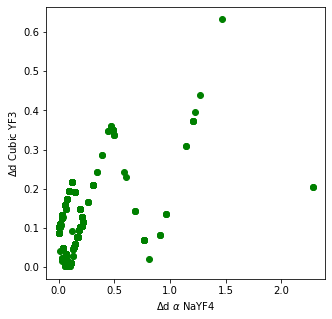

In [195]:
# All data plotting

%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]
Stat_Analysis_data = str('04-22-2021-Alex-Stat_Analysis-Open.csv')

#df = pd.read_csv(Stat_Analysis_data,header=None)

diff_data = genfromtxt(Stat_Analysis_data,delimiter=',')
#print(diff_data)

counter_val = np.array(diff_data[:,0])
d_spacing_detected = np.array(diff_data[:,1])
NYF_diff = np.array(diff_data[:,2])
YF3_diff = np.array(diff_data[:,3])
#hd_diff = np.array(diff_data[:,3])

#for i in range():
#    NYF_diff = np.array(diff_data[4*i,:])
#    YF3_diff = np.array(diff_data[4*i+2,:])

fig_stat = px.scatter(x=NYF_diff,y=YF3_diff,labels={"x" : "aNaYF4 Delta_d","y": "cYF3 Delta_d"})
fig_stat.show()

fig_stat = plt.figure()

colors_choose = ['b','g','r','c','m','y']

for i in range(len(counter_val)):
    #if counter_val[i]==1:
    #plt.scatter(hd_diff[i],cd_diff[i],color=colors_choose[0])
    #if counter_val[i]==2:
    plt.scatter(NYF_diff[i],YF3_diff[i],color=colors_choose[1])
    #if counter_val[i]==3:
    #    plt.scatter(NYF_diff[i],YF3_diff[i],color=colors_choose[2])
plt.xlabel(r'$\Delta$d $\alpha$ NaYF4')
plt.ylabel(r'$\Delta$d Cubic YF3')

#m, b = np.polyfit(hd_diff, cd_diff, 1)
#plt.plot(hd_diff, m*cd_diff + b)

plt.show()

## Selected data for hitogram plotting

[3.14893929 3.14893929 3.08595414 3.14893929 3.01229307 3.08595414
 3.06329077 3.06329077 3.08595414 3.01229307 3.14893929 3.15708663
 3.14893929 3.10134553 3.01229307 3.01229307 3.0411195  3.13283208
 3.12487061 3.15708663 3.15708663 3.15708663 3.10134553 3.10134553
 3.10134553 3.01229307 3.14893929 3.08595414 3.10134553 3.10134553
 3.08595414 3.08595414 3.10134553 3.08595414 3.01229307 3.12487061
 3.01229307 3.13283208 3.01229307 3.12487061 3.06329077 3.12487061
 3.01229307 3.14893929 3.08595414 3.10134553 3.01229307 3.08595414
 3.0411195  3.0411195  3.0411195  3.0411195  3.0411195  3.0411195
 3.0411195  3.15708663 3.0411195  3.0411195  3.15708663 3.0411195
 3.15708663 3.15708663 3.0411195  3.0411195  3.0411195  3.15708663
 3.0411195  3.01229307 3.06329077 3.01229307 3.08595414 3.08595414
 3.10134553 3.06329077 3.13283208 3.08595414 3.01229307 3.08595414
 3.01229307 3.15708663 3.06329077 3.06329077 3.06329077 3.0411195
 3.0411195  3.01229307 3.12487061 3.01229307 3.0411195  3.1248706

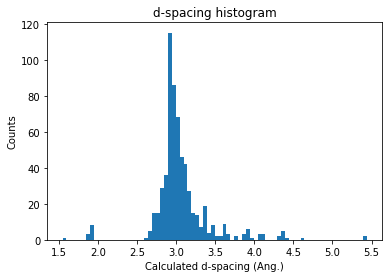

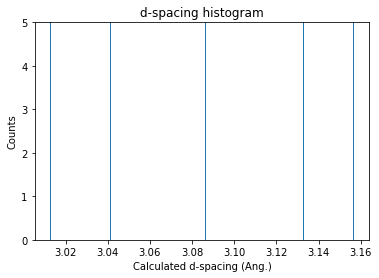

In [205]:
# Selected data for hitogram plotting

%matplotlib inline

##H Histogram Plot

fig = px.bar(y=d_spacing_detected, labels={'x':'Peak no.', 'y':'d-spacing'})
fig.show()

d_111 = []

for i in range(len(d_spacing_detected)):
    if d_spacing_detected[i] > 3.0 and d_spacing_detected[i] < 3.2:
        
        d_111 = np.append(d_111, d_spacing_detected[i])

print(d_111)
print(len(d_111))
#print(d_spacing_detected)
plt.hist(d_spacing_detected, bins = 78,rwidth=1)
plt.xlabel('Calculated d-spacing (Ang.)')
plt.ylabel('Counts')
plt.title('d-spacing histogram')

plt.show()        

plt.hist(d_111, bins = len(d_111),rwidth=0.5)
plt.xlabel('Calculated d-spacing (Ang.)')
plt.ylabel('Counts')
plt.title('d-spacing histogram')

plt.show()


## Frequncy distribution plotting

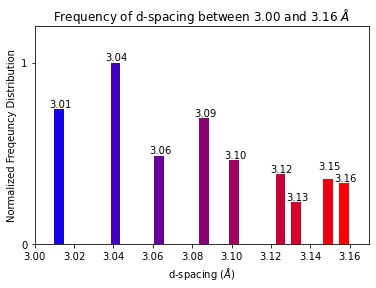

In [258]:
# Frequncy distribution plotting

%matplotlib inline

##H Histogram Plot

#fig = px.bar(y=d_spacing_detected, labels={'x':'Peak no.', 'y':'d-spacing'})
#fig.show()

index_file_path_plot = str('NYF_index')
index_data = genfromtxt(index_file_path_plot + str('.csv'), delimiter=',')

d_spacing_A_plot = np.array(index_data[1:,0])
i_h = np.array(index_data[1:,1])
i_k = np.array(index_data[1:,2])
i_l = np.array(index_data[1:,3])
i_label_plot = np.array(index_data[1:,4])

d_111 = []
l_lim = 3.0
h_lim = 3.16
d_data = []
i_lab = []

for i in range(len(d_spacing_detected)):
    if d_spacing_detected[i] > l_lim and d_spacing_detected[i] < h_lim:
        
        d_111 = np.append(d_111, d_spacing_detected[i])
        
for i in range(len(d_spacing_A_plot)):
    if d_spacing_A_plot[i] > l_lim and d_spacing_A_plot[i] < h_lim:
        
        d_data = np.append(d_data, d_spacing_A_plot[i])
        i_lab = np.append(i_lab, i_label_plot[i])
        

#print(d_111)
#print(len(d_111))
#print(d_spacing_detected)

(unique, counts) = np.unique(d_111, return_counts=True)
frequencies = np.asarray((unique, counts)).T
#print(frequencies)

#print(len(frequencies))

fg = plt.figure()
ax = fg.gca()


for i in range(len(frequencies)):
    
    c_1 = (frequencies[i,0]-3.0)/(3.16-3.0)
    c_gray_1 = c_1
    spot_col_1 = (np.round((0+c_gray_1),2),0.0,np.round((1-c_gray_1),2),1)
    
    ax.bar(frequencies[i,0],frequencies[i,1]/np.max(frequencies[:,1]),width=0.005,color=spot_col_1)
    
    if i==len(frequencies)-2:
        ax.text(frequencies[i,0]-0.0050,(frequencies[i,1]+2)/np.max(frequencies[:,1]),'%.2f'%frequencies[i,0])  
    else:
        ax.text(frequencies[i,0]-0.0050,(frequencies[i,1]+0.50)/np.max(frequencies[:,1]),'%.2f'%frequencies[i,0])
    #ax.axhline(y=frequencies[i,1],xmin=0,xmax=(frequencies[i,0]-l_lim)/(h_lim-l_lim),color='k',linestyle='--')
    
#for j in range(len(d_data)):
    #if i_lab[j] == 0:
        #color_lab = 'k'
        #leg_lab = '[0,0,2] - Hex. graphite'
    #else:
        #color_lab = 'b'
        #leg_lab = '[1,0,0] - Cubic diamond'
    #ax.axvline(x=d_data[j],color=color_lab,linestyle='--',label=leg_lab)
ax.set_xlabel(r'd-spacing ($\AA$)')
ax.set_ylabel('Normalized Freqeuncy Distribution')
ax.set_title(r'Frequency of d-spacing between %.2f and %.2f $\AA$'%(l_lim,h_lim))
#ax.legend(loc='upper right')
#legend.set_draggable(True)
ax.set_xlim(l_lim,h_lim+0.01)
ax.set_ylim(0,1.2)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
#fg.show()
#fg.savefig('04-22-2021-Alex-Open-Histogram.eps',dpi=600)